# Dataloader

In [53]:
import os
from PIL import Image, UnidentifiedImageError
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm

In [ ]:
# Set kaggle API
!pip install --upgrade kaggle==1.7.4.2 --force-reinstall --no-deps
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"","key":""}')

!chmod 600 /root/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# Download dataset
!mkdir '/content/data'
!kaggle datasets download -d nirmalsankalana/crop-pest-and-disease-detection -p /content/data --unzip

mkdir: cannot create directory ‘/content/data’: File exists
Dataset URL: https://www.kaggle.com/datasets/nirmalsankalana/crop-pest-and-disease-detection
License(s): CC0-1.0


In [6]:
# DATAPATH
directory_path = "/content/data"

# LIST ALL FILE IN THE DIRECTORY
files = os.listdir(directory_path)

print(files)


['Maize fall armyworm', 'Maize leaf blight', 'Tomato healthy', 'Cassava mosaic', 'Maize streak virus', 'Maize grasshoper', 'Maize healthy', 'Cassava healthy', 'Cashew gumosis', 'Tomato septoria leaf spot', 'Cashew anthracnose', 'Cassava green mite', 'Maize leaf spot', 'Cashew leaf miner', 'Cassava bacterial blight', 'Maize leaf beetle', 'Tomato verticulium wilt', 'Cassava brown spot', 'Tomato leaf blight', 'Cashew healthy', 'Cashew red rust', 'Tomato leaf curl']


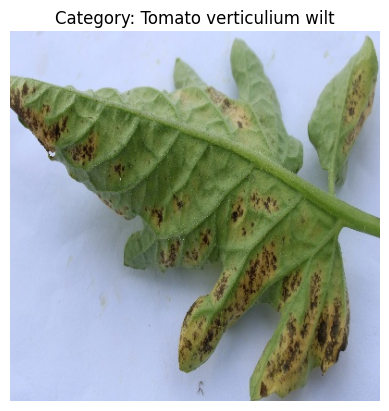

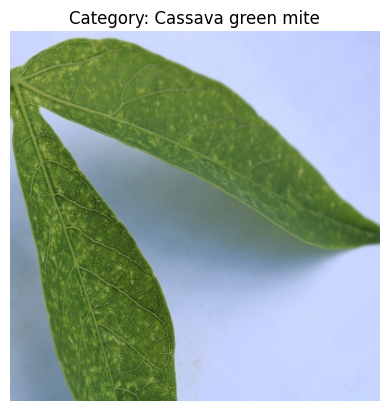

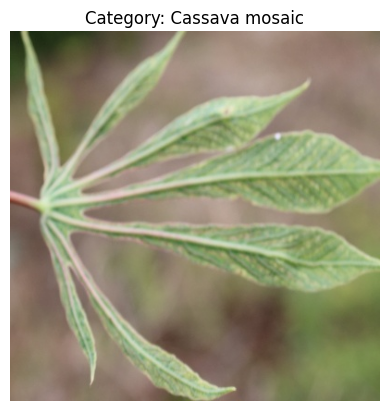

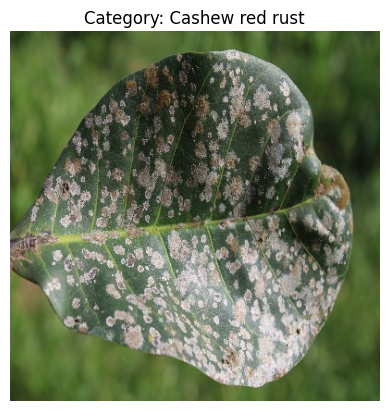

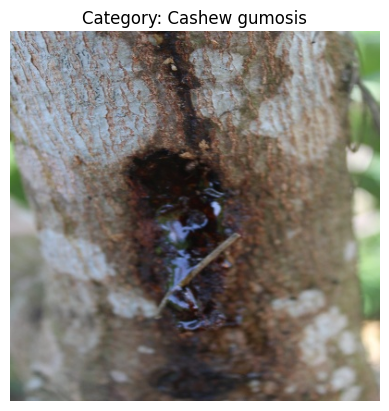

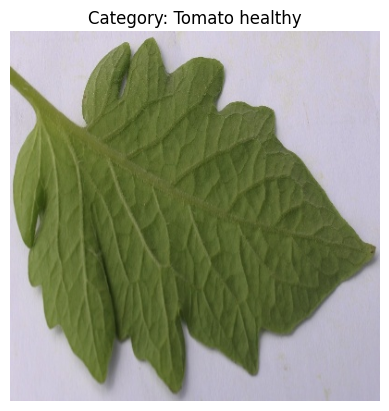

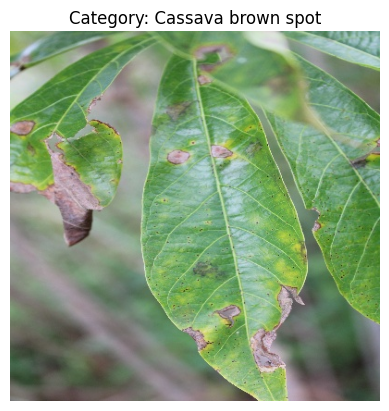

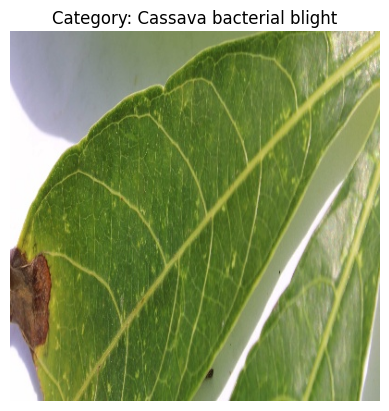

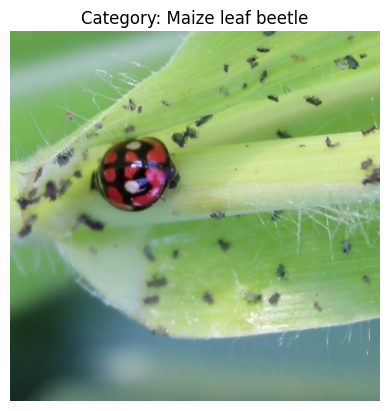

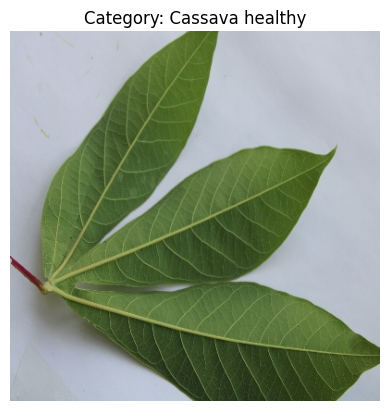

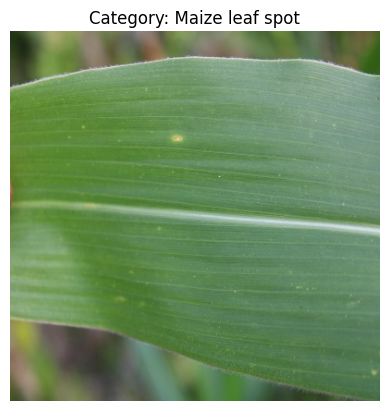

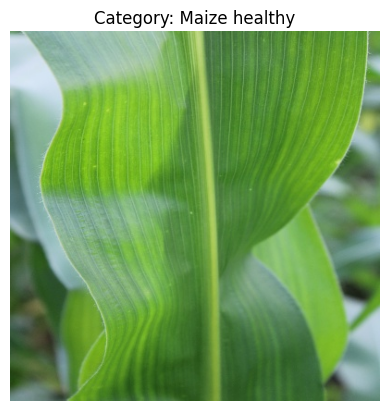

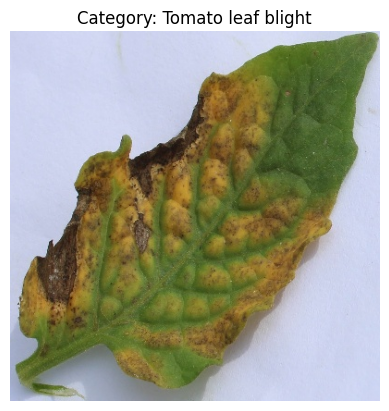

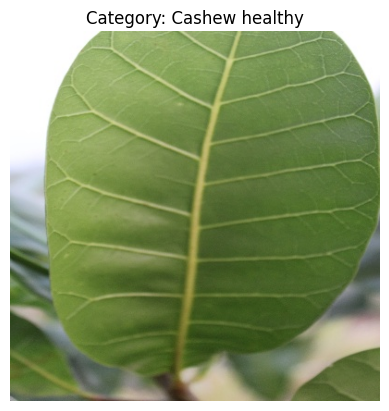

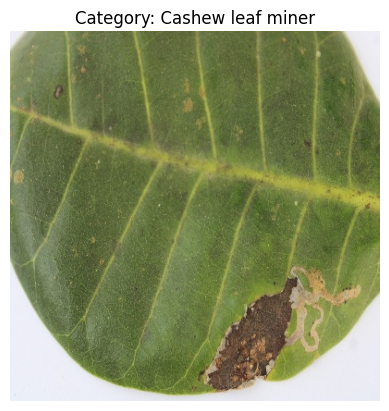

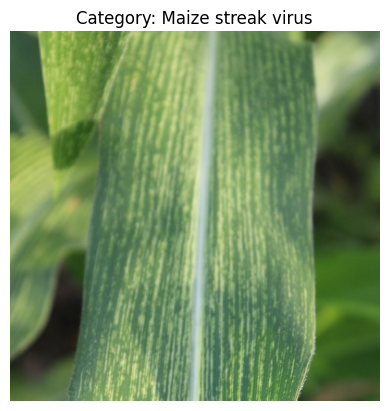

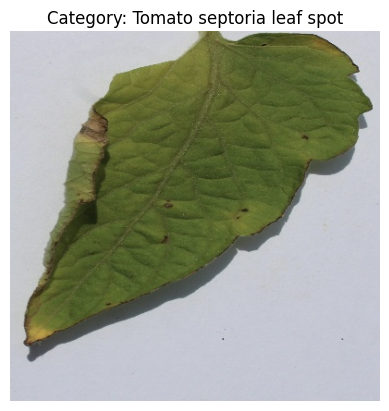

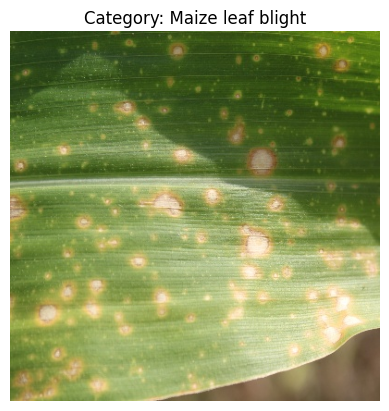

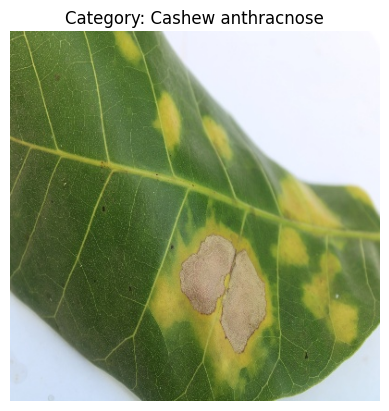

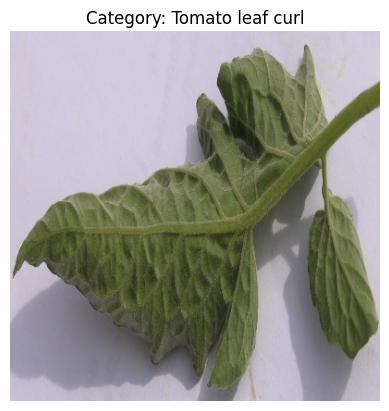

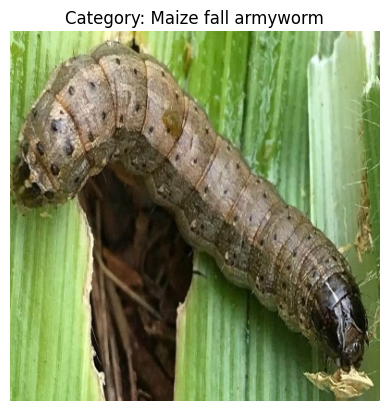

In [26]:
# ALL CATEGORIES LIST
categories = ['Tomato verticulium wilt', 'Cassava green mite', 'Cassava mosaic', 'Cashew red rust', 'Cashew gumosis',
              'Tomato healthy', 'Cassava brown spot', 'Cassava bacterial blight', 'Maize leaf beetle', 'Cassava healthy',
              'Maize leaf spot', 'Maize healthy', 'Tomato leaf blight', 'Cashew healthy', 'Cashew leaf miner',
              'Maize streak virus', 'Tomato septoria leaf spot', 'Maize leaf blight',
              'Cashew anthracnose', 'Tomato leaf curl', 'Maize fall armyworm']

#LOOP THROUGH EACH CATEGORY AND DISPALY AN IMAGE
for category in categories:
    # DATAPATH
    category_path = os.path.join("/content/data", category)

    #LIST ALL FILES IN THE SUBDIRECTORY
    files_in_category = os.listdir(category_path)

    #CHOOSE THE 1ST FILE IN THE LIST
    image_filename = files_in_category[0]

    # CREATE THE FULL PATH TO THE IMAGE
    image_path = os.path.join(category_path, image_filename)


    img = mpimg.imread(image_path)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Category: {category}')
    plt.show()



Processing 'Maize fall armyworm': 100%|██████████| 285/285 [00:00<00:00, 858.03it/s]


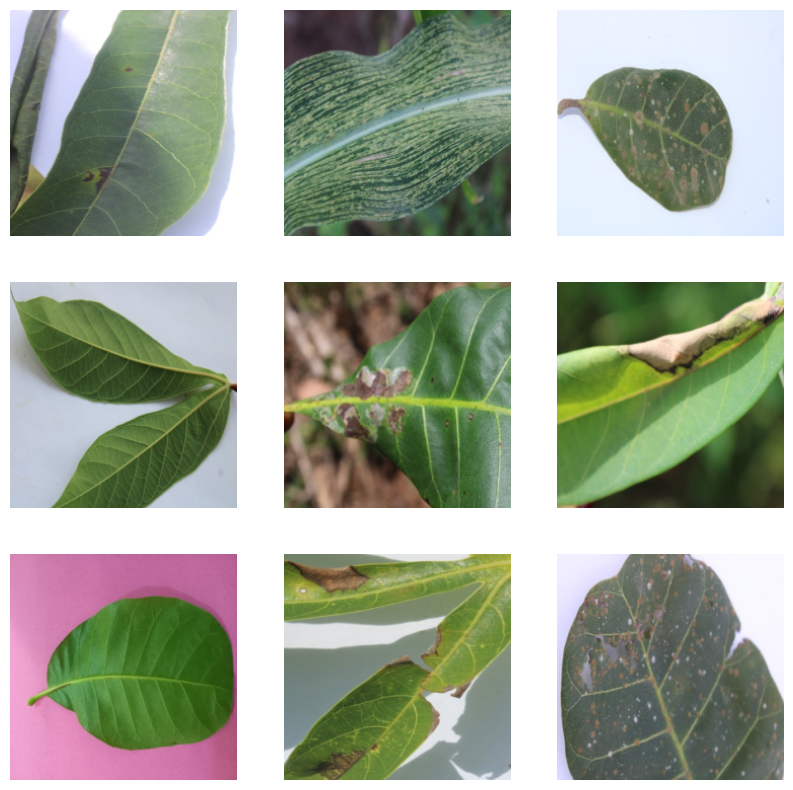

In [ ]:
# Categories
['Tomato verticulium wilt', 'Cassava green mite', 'Cassava mosaic', 'Cashew red rust', 'Cashew gumosis',
              'Tomato healthy', 'Cassava brown spot', 'Cassava bacterial blight', 'Maize leaf beetle', 'Cassava healthy',
              'Maize leaf spot', 'Maize grasshoper', 'Maize healthy', 'Tomato leaf blight', 'Cashew healthy', 'Cashew leaf miner',
              'Maize streak virus', 'Tomato septoria leaf spot', 'Maize leaf blight',
              'Cashew anthracnose', 'Tomato leaf curl', 'Maize fall armyworm']

# Set image path and labels
image_paths = []
image_labels = []

base_path = "/content/data"

for category in categories:
    category_dir = os.path.join(base_path, category)
    filenames = [f for f in os.listdir(category_dir) if f.endswith(".jpg")]
    for filename in tqdm(filenames, desc=f"Processing '{category}'"):
      image_path = os.path.join(category_dir, filename)
      try:
          img = Image.open(image_path)
          img = img.convert("RGB")
          img.load()  # load image each time to remove the damaged image thoroughly
          image_paths.append(image_path)
          image_labels.append(category)
      except (UnidentifiedImageError, OSError):
          continue

# Label encoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_labels)

# Dataset
class CropDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)), # To fit the pretrain model (说是resnet的官方推荐输入大小)
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # To fit the pretrain model (没有很懂啊，加上之后图片群魔乱舞)
])


# Make Dataset and DataLoader
dataset = CropDiseaseDataset(image_paths, encoded_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)

# Visualization
plt.figure(figsize=(10, 10))
for images, labels in dataloader:
    for i in range(9):
        img = images[i].permute(1, 2, 0).numpy()
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    break
plt.show()


In [51]:
print(len(dataset))

24453


# Feature extraction (ResNet18)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet
weights = ResNet18_Weights.DEFAULT
resnet18 = resnet18(weights=weights)

# Remove the final fully connected layer
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])
feature_extractor.to(device)
feature_extractor.eval()

# Extract features

def extract_features(dataloader, model, device):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            features = model(images)                  # shape: [B, 512, 1, 1]
            features = features.view(features.size(0), -1)  # flatten to [B, 512]
            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features), torch.cat(all_labels)

features, labels = extract_features(dataloader, feature_extractor, device)

Extracting features: 100%|██████████| 96/96 [01:39<00:00,  1.03s/it]

Features shape: torch.Size([24453, 512])
Labels shape: torch.Size([24453])


In [55]:
# Results
print("Features shape:", features.shape)  # [N, 512]
print("Labels shape:", labels.shape)      # [N]

Features shape: torch.Size([24453, 512])
Labels shape: torch.Size([24453])
